# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
```

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.


### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


In [1]:
# Imports
from sklearn.datasets import fetch_openml, fetch_20newsgroups
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
# Load Data
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False) # as_frame=False returns numpy arrays

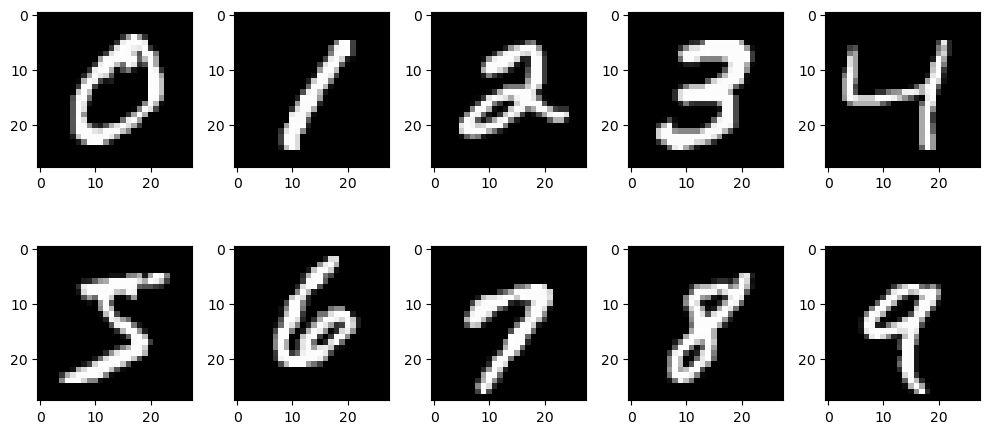

In [3]:
# Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.
plt.figure(figsize=(10, 5))
for digit in range(10):
    plt.subplot(2, 5, digit + 1)
    idx = np.argmax(y == str(digit))  # Get first index where y == digit.
    plt.imshow(X[idx].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

In [4]:
# Divide your data into train and test sets, using 1/7 of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/7.0, random_state=42, stratify=y)

#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

**Answer 1**

The classification rule for this model is:

$$c = \argmax_{j}{\left(\pi_j \prod_i{P_{ji}(x_i)}\right)}$$

Equivalently using log probabilities:

$$c = \argmax_{j}{\left(\log{\pi_j}  + \sum_i{\log P_{ji}(x_i)}\right)}$$


$\pi_j$ is the prior for the digit $y=j$. This can be estimated from the training data as the fraction of training samples with the label $y=j$.

$P_{ji}(x_i)$ is the likelihood of $x_i$ given $y=j$. $P_{ji}(x_i)$ is $p_{ji}$ if $x_i=1$ and $1 - p_{ji}$ otherwise. $p_{ji}$ can be estimated from the training data as the fraction of training samples with the label $y=j$ for which $x_i=1$.

Any $x_i = 1$ that appears in the test data for which $x_i = 0$ in all training data, we have a problem because $P_{ji}(x_i)$ will be 0. We can use Laplace/Lidstone smoothing to solve this problem by adding $\alpha$ to all counts during the training of $p_{ji}$, and also adding $\alpha N_j$ to the denominator (where $N_j$ is the number of training samples with $y=j$).

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


**Answer 2**

In [5]:
# Run a Naive Bayes classifier on the training data and apply predictions on the test data.
# Use the `binarize` parameter of the implementation and set this value to 0.

model = BernoulliNB(binarize=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 


In [6]:
# Let's take a look at our model parameters.
# pi_j is our priors for each class.
print("Shape of priors:", model.class_log_prior_.shape)
print("Priors:", np.exp(model.class_log_prior_))
print("Log Priors:", model.class_log_prior_)
# The priors should be probabilities that sum to 1.
print("Sum of priors:", np.exp(model.class_log_prior_).sum())

# P_ji(x_i) is our likelihood of x_i=1 for class y=j.
print()
print("Shape of feature prob:", model.feature_log_prob_.shape)
print("Feature prob:", np.exp(model.feature_log_prob_))
print("Log feature prob:", model.feature_log_prob_)
# Sum across row (classes) should not sum to 1 as these are likelihoods, not probabilites.
print("Sum of feature prob per class:", np.exp(model.feature_log_prob_).sum(axis=1))

Shape of priors: (10,)
Priors: [0.09861667 0.11253333 0.09985    0.10201667 0.09748333 0.09018333
 0.09823333 0.10418333 0.0975     0.0994    ]
Log Priors: [-2.316515   -2.1845058  -2.30408622 -2.28261908 -2.32807386 -2.40591064
 -2.32040968 -2.26160311 -2.3279029  -2.30860317]
Sum of priors: 0.9999999999999998

Shape of feature prob: (10, 784)
Feature prob: [[0.00016895 0.00016895 0.00016895 ... 0.00016895 0.00016895 0.00016895]
 [0.00014806 0.00014806 0.00014806 ... 0.00014806 0.00014806 0.00014806]
 [0.00016686 0.00016686 0.00016686 ... 0.00016686 0.00016686 0.00016686]
 ...
 [0.00015992 0.00015992 0.00015992 ... 0.00015992 0.00015992 0.00015992]
 [0.00017088 0.00017088 0.00017088 ... 0.00017088 0.00017088 0.00017088]
 [0.00016762 0.00016762 0.00016762 ... 0.00016762 0.00016762 0.00016762]]
Log feature prob: [[-8.68592279 -8.68592279 -8.68592279 ... -8.68592279 -8.68592279
  -8.68592279]
 [-8.8178902  -8.8178902  -8.8178902  ... -8.8178902  -8.8178902
  -8.8178902 ]
 [-8.6983474  -8

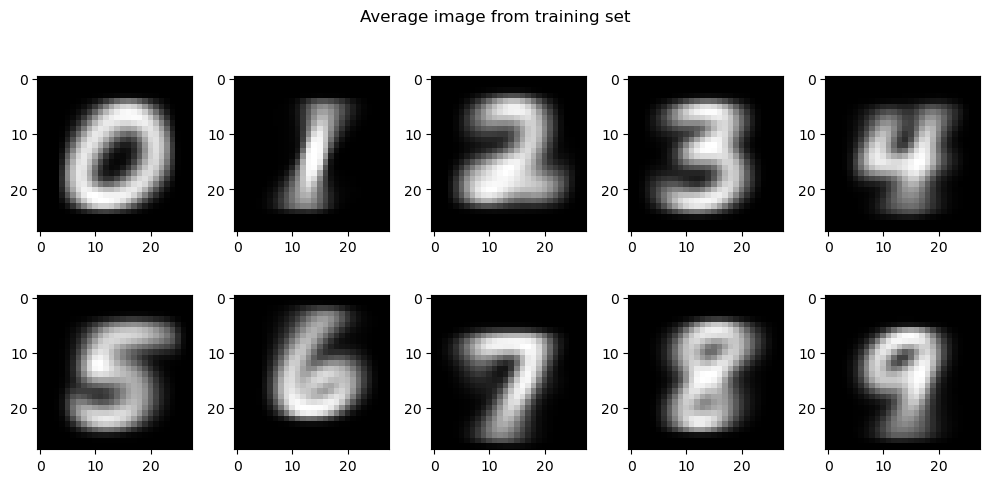

In [7]:
# Plot the mean image of each class.
# Compute probability (not log probability).
prob = np.exp(model.feature_log_prob_)

plt.figure(figsize=(10, 5))
plt.suptitle("Average image from training set")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(prob[i].reshape(28, 28), cmap='gray')
plt.tight_layout()

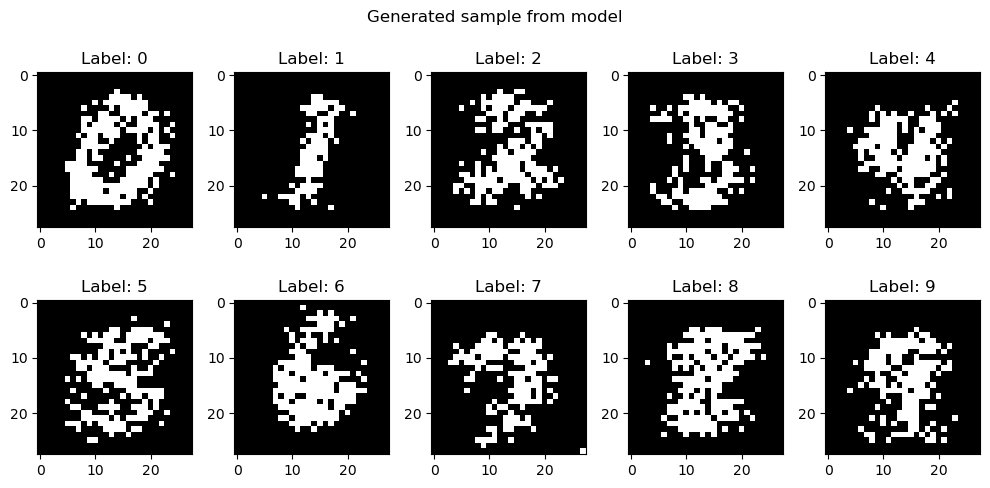

In [8]:
# Generate one sample of each class.
rng = np.random.default_rng()

plt.figure(figsize=(10, 5))
plt.suptitle("Generated sample from model")
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Draw random values from Bernoulli distribution (binomial distribution with n=1).
    digit_samples = rng.binomial(np.ones(prob.shape[1], dtype="int"), prob[i])
    plt.imshow(digit_samples.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {i}")
plt.tight_layout()

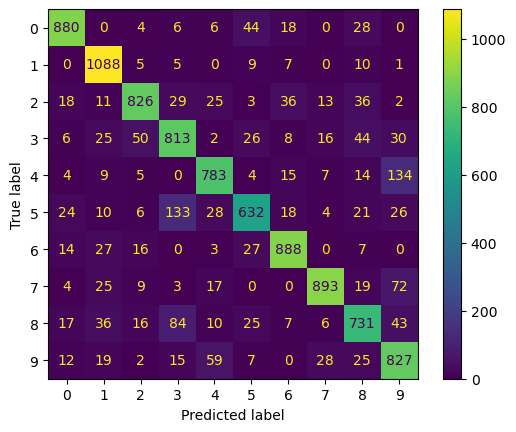

In [9]:
# Plot the confusion matrix of your classifier, as calculated on the test data.
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
plt.show()

In [10]:
# Calculate the total accuracy (fraction of correctly classified images).
print(f"Total accuracy: {metrics.accuracy_score(y_test, y_pred):.2%}")

Total accuracy: 83.61%


#### Summary of the above results
- Label 5 has the lowest score and is visually difficult to distinguish in the images above.
- The highest score was for label 1.
- 133 of the 5s are predicted as 3.
- 134 of the 4s are predicted as 9.
- 84 of the 8s are predicted as 3.
- 72 of the 7s are predicted as 9.
- The misclassifications between labeled and predicted images seem to be associated with pixel distribution: images with different pixel distribution seem less likely to be misclassified, while images with similar pixel distribution seem more likely to be misclassified. 

In [11]:
# How can find the optimal threshold of the binarization part?
# Try grid search with all possible thresholds (takes a few minutes), could also sample the space.
param_grid = {
    "binarize": np.arange(255),
}
best_model = GridSearchCV(model, param_grid, n_jobs=-1)
best_model.fit(X_train, y_train)
print(f"Best binarization threshold: {best_model.best_params_['binarize']}")
print(f"Total accuracy: {metrics.accuracy_score(y_test, best_model.predict(X_test)):.2%}")

Best binarization threshold: 106
Total accuracy: 84.19%


## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`. If there are differences try to think why
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [2]:
X_train, y_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)

In [13]:
newsgroups_train  = fetch_20newsgroups(subset='train', random_state=42, remove=('headers','footers','quotes'))
df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
df.columns = ['text', 'target']

targets = pd.DataFrame(newsgroups_train.target_names)
targets.columns=['title']

In [14]:
# Exploratory Data Analysis
df.head()

,text,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB


In [16]:
df.groupby('target').describe().T

target        0    1    2    3    4    5    6    7    8    9    10   11   12  \
text count   480  584  591  590  578  593  585  594  598  597  600  595  591   
     unique  470  573  571  582  562  583  576  566  585  578  588  584  577   
     top                              Hi,                                      
     freq      8   12   15    6   13    2    4   25   11   16   10   12   14   

target        13   14   15   16   17   18   19  
text count   594  593  599  546  564  465  377  
     unique  583  579  595  536  551  458  363  
     top                                        
     freq     11   13    5    9   12    7   14

In [17]:
df['length'] = df['text'].map(lambda text: len(text))

In [18]:
df.head()

,text,target,length
0,I was wondering if anyone out there could enli...,7,475
1,A fair number of brave souls who upgraded thei...,4,530
2,"well folks, my mac plus finally gave up the gh...",4,1659
3,\nDo you have Weitek's address/phone number? ...,1,95
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,448


In [3]:
# Use sklearn.feature_extraction.text import CountVectorizer to count words (stop_words='english')
vectorizer = CountVectorizer(stop_words="english")
v = vectorizer.fit(X_train)
print(f'Number of words in the training data: {len(v.vocabulary_)}')

Number of words in the training data: 101322


In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0, *wargs, **kwargs):
        super().__init__(*wargs, **kwargs)
        self.alpha = alpha

        # For simplicity, use same class fields as sklearn's MultinomialNB.
        self.classes_ = None  # (n_classes,) ndarray of class labels.
        self.class_count_ = None  # (n_classes,) ndarray containing training sample counts for each class.
        self.class_log_prior_ = None  # (n_classes,) ndarray containing smoothed log probabilities for each class.
        self.feature_count_ = None  # (n_classes, n_features) ndarray containing training samples counts.
        self.feature_log_prob_ = None  # (n_classes, n_features) ndarray containing log probabilities P(x_i|y).
        self.n_features_in_: int = 0  # Number of features.

    def fit(self, X, y):
        self.n_features_in_ = X.shape[1]
        self.classes_ = np.unique(y)
        self.class_count_ = np.zeros(len(self.classes_))
        self.feature_count_ = np.zeros((len(self.classes_), self.n_features_in_))

        # Obtain counts for each class.
        for c_idx, c in enumerate(self.classes_):
            # Get only samples in the class c.
            X_c = X[y==c,:]
            self.class_count_[c_idx] = X_c.shape[0]
            self.feature_count_[c_idx,:] = X_c.sum(axis=0)
    
        # Compute log probabilities.
        self._set_log_prior()
        self._set_feature_log_prob()

    def predict_log_proba(self, X):
        ll = self._get_log_likelihood(X)
        # Need to normalize log likelihood by P(x) = P(f_1, ..., f_n).
        log_prob_x = logsumexp(ll, axis=1)
        return ll - np.atleast_2d(log_prob_x).T
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        return self.classes_[np.argmax(self._get_log_likelihood(X), axis=1)]

    def _get_log_likelihood(self, X):
        """Returns un-normalized log likelihood, as (possibly sparse) array (n_samples, n_classes)."""
        # For each sample the log probability for each class is:
        #   the log prior plus the sum of feature log probabilities scaled/multiplied by their occurance in X.
        # Use X.dot(...) rather than np.dot(X, ...) in order to dramatically increase speed if X is sparse.
        return X.dot(self.feature_log_prob_.T) + self.class_log_prior_

    def _set_log_prior(self):
        """Compute log probability of class priors from training data."""
        # Priors are number of counts per class over total number of training samples.
        self.class_log_prior_ = np.log(self.class_count_) - np.log(self.class_count_.sum())

    def _set_feature_log_prob(self):
        """Compute feature log probability after applying smoothing to features counts."""
        smoothed_feature_counts = self.feature_count_ + self.alpha
        smoothed_class_counts = smoothed_feature_counts.sum(axis=1)
        # Feature probability is (smoothed) feature counts per class over (smoothed) number of samples in class.
        self.feature_log_prob_ = np.log(smoothed_feature_counts) - np.log(smoothed_class_counts.reshape(-1, 1))


In [20]:
# Use my NB implementation.
print("Using my implementation:")
my_model = Pipeline([
    ("vec", CountVectorizer(stop_words='english')),
    ("nb", NaiveBayes()),
])
my_model.fit(X_train, y_train)
y_pred = my_model.predict(X_test)
print(f"Total accuracy: {metrics.accuracy_score(y_test, y_pred):.2%}")
print(metrics.classification_report(y_test, y_pred))

Using my implementation:
Total accuracy: 63.44%
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       319
           1       0.58      0.69      0.63       389
           2       0.40      0.01      0.01       394
           3       0.53      0.72      0.61       392
           4       0.74      0.56      0.64       385
           5       0.56      0.81      0.66       395
           6       0.85      0.69      0.76       390
           7       0.82      0.70      0.76       396
           8       0.91      0.62      0.73       398
           9       0.94      0.74      0.83       397
          10       0.58      0.91      0.71       399
          11       0.54      0.79      0.64       396
          12       0.71      0.49      0.58       393
          13       0.81      0.79      0.80       396
          14       0.72      0.75      0.73       394
          15       0.46      0.91      0.61       398
          16       0.57      0.61

In [21]:
# Use sklearn's implementation.
print("Using sklearn's implementation:")
skl_model = Pipeline([
    ("vec", CountVectorizer(stop_words='english')),
    ("nb", MultinomialNB()),
])
skl_model.fit(X_train, y_train)
y_pred = skl_model.predict(X_test)
print(f"Total accuracy: {metrics.accuracy_score(y_test, y_pred):.2%}")
print(metrics.classification_report(y_test, y_pred))

Using sklearn's implementation:
Total accuracy: 63.44%
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       319
           1       0.58      0.69      0.63       389
           2       0.40      0.01      0.01       394
           3       0.53      0.72      0.61       392
           4       0.74      0.56      0.64       385
           5       0.56      0.81      0.66       395
           6       0.85      0.69      0.76       390
           7       0.82      0.70      0.76       396
           8       0.91      0.62      0.73       398
           9       0.94      0.74      0.83       397
          10       0.58      0.91      0.71       399
          11       0.54      0.79      0.64       396
          12       0.71      0.49      0.58       393
          13       0.81      0.79      0.80       396
          14       0.72      0.75      0.73       394
          15       0.46      0.91      0.61       398
          16       0.57   

In [22]:
# Plot the learning curve.

def plot_learning_curve(trains_sizes_abs, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 8))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    lw = 2
    plt.plot(
        trains_sizes_abs, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        trains_sizes_abs,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        trains_sizes_abs, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        trains_sizes_abs,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")

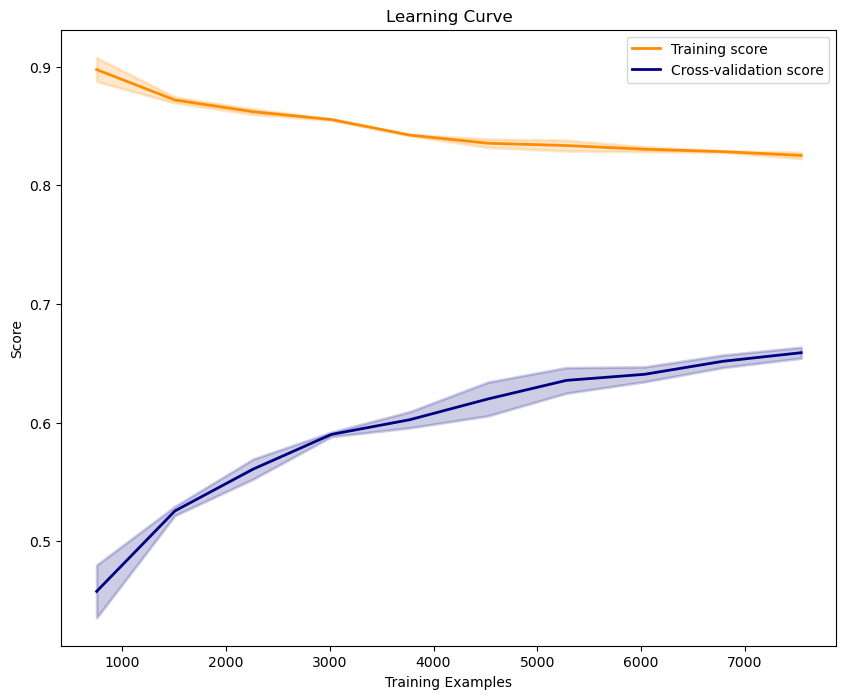

In [23]:
from sklearn.model_selection import learning_curve

plot_learning_curve(*learning_curve(skl_model, X_train, y_train, train_sizes=np.arange(0.1, 1.1, 0.1), cv=3, scoring="accuracy"))
plt.title("Learning Curve")
plt.show()

##### Is the model in the bias or variance regime (you can use the built in model for doing the analysis)?

- Based on the learning curve, we are clearly overfitting (low bias, high variance) since our training scores are much higher than CV scores. We need more data to reduce variance and limit overfitting.

In [24]:
# optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).
parameters = {
    'vec__max_df': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'vec__max_features': np.logspace(1, 6, 6, dtype="int"),
}
grid = GridSearchCV(skl_model, cv=3, param_grid=parameters, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best tuned model (max_df={best_params['vec__max_df']:.1f}, max_features={best_params['vec__max_features']}):")
print(f"    Training accuracy: {metrics.accuracy_score(y_train, grid.predict(X_train)):.2%}")
print(f"    Test accuracy: {metrics.accuracy_score(y_test, grid.predict(X_test)):.2%}")

Best tuned model (max_df=0.3, max_features=10000):
    Training accuracy: 77.67%
    Test accuracy: 62.79%
